In [66]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from io import StringIO

In [3]:
def fetch_cbr(date):
    formatted_date = date.strftime('%Y/%m/%d')
    response = requests.get(f"https://www.cbr-xml-daily.ru/archive/{formatted_date}/daily_json.js")
    if response.status_code == 200:
        json_data = response.json()
        if 'Valute' in json_data and 'USD' in json_data['Valute']:
            return {'date': date, 'usd_rate': json_data['Valute']['USD']['Value']}
    return None

In [4]:
def fetch_ipc():
    url = "https://www.statbureau.org/ru/russia/cpi/index.data.csv"
    response = requests.get(url)
    if response.status_code == 200:
        df_cbr = pd.read_csv(url)
    return df_cbr

In [5]:
end_date = datetime.now() - timedelta(days=4)
start_date = end_date - pd.DateOffset(years=5)

dates = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]
data1 = [] 

with ThreadPoolExecutor(max_workers=6*2+1) as executor:
    futures = [executor.submit(fetch_cbr, date) for date in dates]
    for future in tqdm(as_completed(futures), total=len(dates)):
        result = future.result()
        if result:
            data1.append(result)

data1 = [d for d in data1 if d is not None] 

df_cbr = pd.DataFrame(data1)


100%|██████████| 1827/1827 [03:00<00:00, 10.12it/s]


In [6]:
df_ipc = fetch_ipc()

In [7]:
df_cbr.head()

,date,usd_rate
0,2018-12-05 11:53:34.848212,66.4467
1,2018-12-11 11:53:34.848212,66.2416
2,2018-12-04 11:53:34.848212,66.2921
3,2018-11-29 11:53:34.848212,66.9436
4,2018-12-06 11:53:34.848212,66.8242


In [8]:
df_ipc.head()

,Год,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь
0,1991,106.20,104.80,106.30,163.50,103.00,101.20,100.60,100.50,101.10,103.50,108.90,112.10
1,1992,345.30,138.00,129.90,121.70,111.90,119.10,110.60,108.60,111.50,122.90,126.10,125.20
2,1993,125.80,124.70,120.10,118.70,118.10,119.90,122.39,126.00,123.00,119.50,116.39,112.50
3,1994,117.90,110.82,107.41,108.49,106.91,106.00,105.33,104.62,107.96,115.00,114.61,116.44
4,1995,117.77,111.02,108.94,108.47,107.93,106.66,105.38,104.56,104.46,104.72,104.56,103.20


In [9]:
df_ipc_melted = df_ipc.melt(id_vars=['Год'], var_name='month', value_name='ipc')
df_ipc_melted.columns = ['year','month','ipc']

month_map = {' Январь': '01', ' Февраль': '02', ' Март': '03', ' Апрель': '04', ' Май': '05', ' Июнь': '06',
             ' Июль': '07', ' Август': '08', ' Сентябрь': '09', ' Октябрь': '10', ' Ноябрь': '11', ' Декабрь': '12'}

df_ipc_melted['month'] = df_ipc_melted['month'].map(month_map)
df_ipc_melted['date'] = pd.to_datetime(df_ipc_melted['year'].astype(str) + '-' + df_ipc_melted['month'])
df_ipc_melted.drop(columns=['year', 'month'], inplace=True)

In [10]:
end_date = pd.to_datetime("now")- timedelta(days=4)
start_date = end_date - pd.DateOffset(years=5)
df_ipc_filtered = df_ipc_melted[(df_ipc_melted['date'] >= start_date) & (df_ipc_melted['date'] <= end_date)]

df_ipc_final = df_ipc_filtered[['date', 'ipc']]
df_ipc_final['date'] = pd.to_datetime(df_ipc_final['date']) + pd.offsets.MonthEnd(0)
display(df_ipc_final.head(2))
display(df_ipc_final.tail(2))

,date,ipc
28,2019-01-31,101.01
29,2020-01-31,100.40


,date,ipc
393,2021-12-31,100.82
394,2022-12-31,100.78


In [11]:
df_cbr.set_index('date', inplace=True)
df_cbr_monthly = df_cbr.resample('M').last()
df_cbr_monthly.reset_index(inplace=True)
display(df_cbr_monthly.head(2))
display(df_cbr_monthly.tail(2))

,date,usd_rate
0,2018-11-30,66.6342
1,2018-12-31,69.4706


,date,usd_rate
59,2023-10-31,93.2435
60,2023-11-30,88.6102


In [62]:
df_merged = pd.merge(df_cbr_monthly, df_ipc_final.dropna(how = 'any'), how = 'inner',  on = 'date')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      59 non-null     datetime64[ns]
 1   usd_rate  59 non-null     float64       
 2   ipc       59 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.5 KB


In [69]:
correlation = df_merged['usd_rate'].corr(df_merged['ipc'])
print("Корреляция между курсом рубля и инфляцией:", correlation)

Корреляция между курсом рубля и инфляцией: 0.3271242813326661


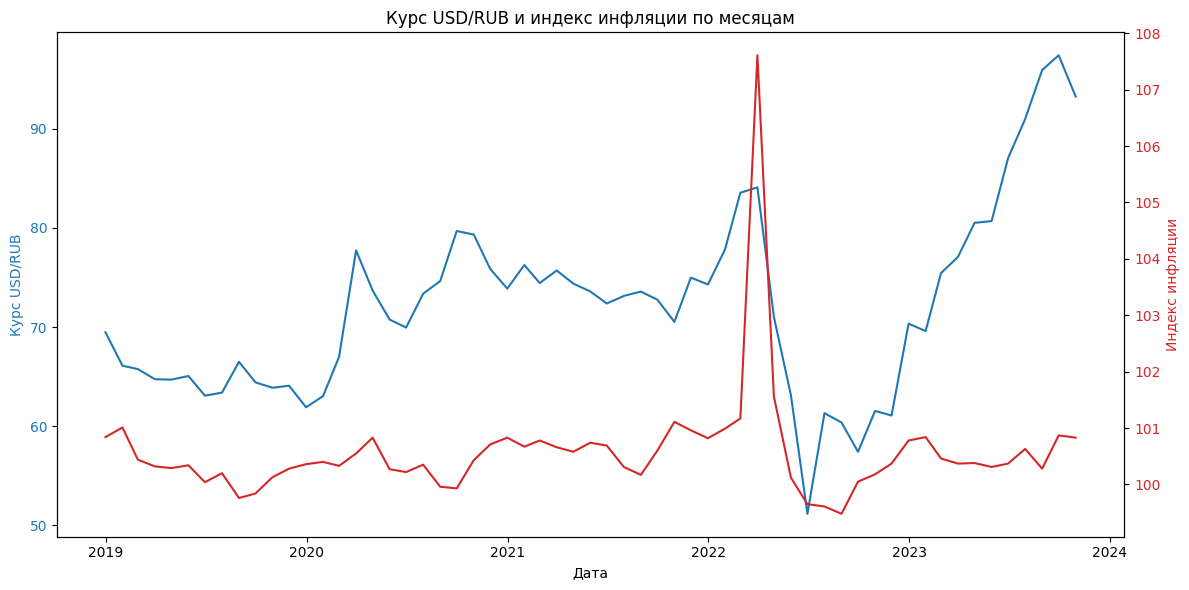

In [70]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Курс валюты на основной оси Y (ax1)
color = 'tab:blue'
ax1.set_xlabel('Дата')
ax1.set_ylabel('Курс USD/RUB', color=color)
ax1.plot(df_merged['date'], df_merged['usd_rate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Создание второй оси Y для инфляции
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Индекс инфляции', color=color)
ax2.plot(df_merged['date'], df_merged['ipc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Добавление названия графика и отображение
plt.title('Курс USD/RUB и индекс инфляции по месяцам')
fig.tight_layout()
plt.show()